In [1]:
from proteus.iproteus import * 
from proteus import default_n, default_s, default_so
Profiling.logLevel=5
Profiling.verbose=False

In [2]:
import circular_tank.wavesloshing_laminar_unstruct_medium_so as so
display_src(so)

```Python
from proteus.default_so import *
from proteus import Context
import wavesloshing_laminar_unstruct_medium
Context.setFromModule(wavesloshing_laminar_unstruct_medium)
ctx = Context.get()

if ctx.useOnlyVF:
    pnList = [("twp_navier_stokes_p", "twp_navier_stokes_n"),
              ("vof_p",               "vof_n")]
else:
    pnList = [("twp_navier_stokes_p", "twp_navier_stokes_n"),
              ("vof_p",               "vof_n"),
              ("ls_p",                "ls_n"),
              ("redist_p",            "redist_n"),
              ("ls_consrv_p",         "ls_consrv_n")]


if ctx.useRANS > 0:
    pnList.append(("kappa_p",
                   "kappa_n"))
    pnList.append(("dissipation_p",
                   "dissipation_n"))

name = "wavesloshing_laminar_unstruct_medium_p"

if ctx.timeDiscretization == 'flcbdf':
    systemStepControllerType = Sequential_MinFLCBDFModelStep
    systemStepControllerType = Sequential_MinAdaptiveModelStep
else:
    systemStepControllerType = Sequential_MinAdaptiveModelStep

needEBQ_GLOBAL = False
needEBQ = False

tnList = [0.0, ctx.dt_init] + [i*ctx.dt_fixed for i in range(1,ctx.nDTout+1)]

```


In [3]:
from proteus  import Context
ctx = Context.get()
print ctx.domain

<proteus.Domain.PlanarStraightLineGraphDomain instance at 0x7fa852ca2ea8>


In [4]:
%matplotlib inline
from IPython.html.widgets import interactive, fixed, FloatSlider
def buildCircularTank(he=2.0/20.0, domain=ctx.domain):
    from matplotlib import pyplot, collections
    #
    #set up a cicular domain
    #
    from math import pi, ceil, cos, sin
    nvertices = nsegments = int(ceil(2.0*pi/he))
    dtheta = 2.0*pi/float(nsegments)
    vertices= []
    vertexFlags = []
    segments = []
    segmentFlags = []
    for i in range(nsegments):
        theta = pi/2.0 - i*dtheta
        vertices.append([0.5+cos(theta),0.5+sin(theta)])
        if i in [nvertices-1,0,1]:
            vertexFlags.append(domain.boundaryTags['top'])
        else:
            vertexFlags.append(boundaryTags['bottom'])
        segments.append([i,(i+1)%nvertices])
        if i in [nsegments-1,0]:
            segmentFlags.append(domain.boundaryTags['top'])
        else:
            segmentFlags.append(domain.boundaryTags['bottom'])
        boundaryTags = domain.boundaryTags
    domain = Domain.PlanarStraightLineGraphDomain(vertices=vertices,
                                                  vertexFlags=vertexFlags,
                                                  segments=segments,
                                                  segmentFlags=segmentFlags)
    #go ahead and add a boundary tags member 
    domain.boundaryTags = boundaryTags
    domain.writePoly("mesh")
    #
    #finished setting up circular domain
    #
    plot=True
    if  plot:
        lines = []
        cmap = pyplot.get_cmap("hsv")
        c = []
        sF_max = float(max(domain.segmentFlags))
        for s,sF in zip(domain.segments,domain.segmentFlags):
            lines.append([domain.vertices[s[0]],domain.vertices[s[1]]])
            c.append(cmap(float(sF/sF_max)))
        lc = collections.LineCollection(lines,colors=c,linewidths=3)
        fig, ax = pyplot.subplots()
        ax.add_collection(lc)
        ax.margins(0.1)
        ax.set_aspect('equal')
    return domain
domain_widget = interactive(buildCircularTank,
                                he=FloatSlider(min=0.0025, value=1.0/10.0, max=0.25, step=1.0/20),
                                domain=fixed(ctx.domain))

:0: FutureWarning: IPython widgets are experimental and may change in the future.


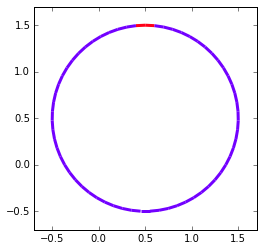

In [5]:
display(domain_widget)

In [6]:
for k in ctx.domain.__dict__.keys():
    ctx.domain.__dict__[k] = domain_widget.result.__dict__[k]

In [7]:
from proteus import Comm
from petsc4py import PETSc
import os
from importlib import import_module

pList=[]
nList=[]
so.sList=[]
OptDB = PETSc.Options()
for (p,n) in so.pnList:
    so.sList.append(default_s)
    pList.append(import_module('circular_tank.'+p))
    nList.append(import_module('circular_tank.'+n))
    pList[-1].name = p
    #nList[-1].multilevelLinearSolver = default_n.KSP_petsc4py
    #nList[-1].levelLinearSolver = default_n.KSP_petsc4py
    #OptDB.setValue(nList[-1].linear_solver_options_prefix+"ksp_type", "preonly")
    #OptDB.setValue(nList[-1].linear_solver_options_prefix+"pc_type", "lu")
    #OptDB.setValue(nList[-1].linear_solver_options_prefix+"pc_factor_mat_solver_package","superlu_dist")
opts.save_dof = True
opts.dataDir='.'
opts.probDir='.'
Profiling.logLevel=3
Profiling.verbose=False

In [8]:
ns = NumericalSolution.NS_base(so, pList, nList, so.sList, opts)

TriangleBaseMesh nbase=1 baseFlags= VApq30Dena0.00052029 


In [9]:
from threading import Thread
# Create a thread wrapper for the simulation.  The target must be an argument-less
# function so we wrap the call to `calculateSolution` in a simple lambda:
simulation_thread = Thread(target = lambda : ns.calculateSolution('circular_tank'))

In [18]:
from IPython.core.display import clear_output

def plot_current_results(in_place=True):
    from matplotlib import  pyplot as plt
    """Makes a blocking call to retrieve remote data and displays the solution mesh
    as a contour plot.
    
    Parameters
    ----------
    in_place : bool
        By default it calls clear_output so that new plots replace old ones.  Set
        to False to allow keeping of all previous outputs.
    """
    model = ns.modelList[1].levelModelList[-1]
    nodes = model.mesh.nodeArray
    triangles = model.mesh.elementNodesArray
    x = nodes[:,0]
    y = nodes[:,1]
    u = model.u[0].dof_last
    fig, ax = plt.subplots()
    ax.tricontourf(x, y, triangles, u)
    if in_place:
        clear_output()
    plt.axis('equal')
    display(fig)
    return fig

def monitor_simulation(refresh=5.0, plots_in_place=True):
    """Monitor the simulation progress and call plotting routine.

    Supress KeyboardInterrupt exception if interrupted, ensure that the last 
    figure is always displayed and provide basic timing and simulation status.

    Parameters
    ----------
    refresh : float
      Refresh interval between calls to retrieve and plot data.  The default
      is 5s, adjust depending on the desired refresh rate, but be aware that 
      very short intervals will start having a significant impact.

    plots_in_place : bool
       If true, every new figure replaces the last one, producing a (slow)
       animation effect in the notebook.  If false, all frames are plotted
       in sequence and appended in the output area.
    """
    import datetime as dt, time
    from matplotlib  import pyplot  as plt
    if not simulation_thread.is_alive():
        fig = plot_current_results(in_place=plots_in_place)
        fig.close('all')
        print 'Simulation has already finished, no monitoring to do.'
        return
    
    t0 = dt.datetime.now()
    fig = None
    try:
        while simulation_thread.is_alive():
            fig = plot_current_results(in_place=plots_in_place)
            plt.close('all') # prevent re-plot of old figures
            time.sleep(refresh) # so we don't hammer the server too fast
    except (KeyboardInterrupt):#, error.TimeoutError):
        msg = 'Monitoring interrupted, simulation is ongoing!'
    else:
        msg = 'Simulation completed!'
    tmon = dt.datetime.now() - t0
    if plots_in_place and fig is not None:
        clear_output()
        display(fig)
    print msg
    print 'Monitored for: %s.' % tmon

In [11]:
simulation_thread.start()

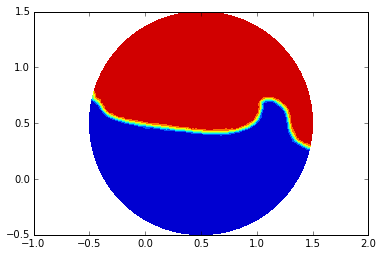

Monitoring interrupted, simulation is ongoing!
Monitored for: 0:00:50.303352.


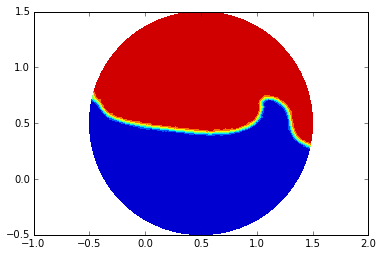

In [19]:
monitor_simulation()